# Levenshtein


Un análisis extra: ¿qué pasa con la distancia media de levenshtein de cada palabra al resto?



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from contrastes import read_occurrence_dataframe

df = read_occurrence_dataframe("../output/provinces_words.csv")

print("Total de palabras: {}".format(df.shape[0]))

Total de palabras: 2330114


# Distancia media de Levenshtein a una palabra con más ocurrencias?

Veamos en cada "slot" de a 10 ocurrencias qué pasa con la distancia media a una forma "mejor"

In [2]:
from nltk.metrics import edit_distance

palabra = "culiaw"
occ = df.loc[palabra].cant_palabra

palabras_otras = df[df.cant_palabra > occ].index


min_dist = min(edit_distance(palabra, otra_palabra) for otra_palabra in palabras_otras)

print("Mínimo distancia de edición para {} => {}".format(palabra, min_dist))
ejemplos = [w for w in palabras_otras if edit_distance(w, palabra) == min_dist]
print("ejemplos = {}".format(ejemplos))

Mínimo distancia de edición para culiaw => 1
ejemplos = ['culia', 'culiaa', 'culiao', 'culiar', 'culiau']


In [3]:
def more_common_form(df, palabra):
    occ = df.loc[palabra].cant_palabra
    
    candidatas = df[df.cant_palabra > (occ+5)].index
    
    
    min_dist = None 
    
    for w in candidatas:
        if min_dist is None:
            min_dist = edit_distance(w, palabra)
            ejemplos = [w]
        else:
            try:
                dist = edit_distance(w, palabra)

                if dist < min_dist:
                    min_dist = dist
                    ejemplos = [w]
                elif dist == min_dist:
                    ejemplos.append(w)
            except TypeError:
                pass
    return min_dist, ejemplos

In [4]:
more_common_form(df, "angaa")

(1, ['anaa', 'anaaa', 'andaa', 'anga', 'angaaa', 'angau'])

In [5]:
more_common_form(df, "kuliau")

(1, ['culiau', 'kulia', 'kuliao'])

In [6]:
more_common_form(df, "caarajo")
distances[upper] = dict(distances)

(1, ['caaarajo', 'carajo'])

A ver, probemos con un poco menos y usando otras métricas (no sólo la media)

In [15]:
%%time 

import random
import multiprocessing
from contextlib import closing

def dist(w):
    return (w, more_common_form(df, w))

distances = dict()

for i in range(1, 30):
    lower = 20 * (i-1)
    upper = 20 * i
    
    print(lower, upper)
    
    palabras = df[(lower <= df.cant_palabra) & (df.cant_palabra < upper)].index 
    palabras = [p for p in palabras if isinstance(p, str)]
    
    samples = random.sample(palabras, 120)
    
    with closing(multiprocessing.Pool(4, maxtasksperchild=1)) as pool:
        distances[upper] = dict(pool.map(dist, samples))


0 20
20 40
40 60
60 80
80 100
100 120
120 140
140 160
160 180
180 200
200 220
220 240
240 260
260 280
280 300
300 320
320 340
340 360
360 380
380 400
400 420
420 440
440 460
460 480
480 500
500 520
520 540
540 560
560 580
CPU times: user 5.17 s, sys: 13.4 s, total: 18.6 s
Wall time: 2h 55min 17s


Veamos, de cada "slot", las palabras más "raras"


In [36]:
import numpy as np

for bound, words in distances.items():
    stranger_words = sorted(list(words.items()), key=lambda x: -x[1][0])[:15]
    
    print("="*80)
    print("Palabras rango {}\n".format((bound-20, bound)))
    print("Media de distancia = {}".format(np.array([d for _, (d, _) in stranger_words]).mean()))
    
    for word, (dist, similar_words) in stranger_words:
        print("* {} --> dist = {} ({})".format(word, dist, similar_words[:3]))

Palabras rango (0, 20)

Media de distancia = 5.733333333333333
* hijosdeunacamionadadeeeputaaa --> dist = 14 (['hijodelachingadaaa', 'hijosdemilputaaa', 'hijosderemilputaaa'])
* recuerdosdesuperclásico --> dist = 11 (['superclásico'])
* jajajajajajajajajajajajajajajajajajajajajajajajaajajajajajajajajanqjaanjajaajajajja --> dist = 7 (['jajajajajajajajajajajajajajajajajajajajajajajajajajajajajajajajajajajajajaja', 'jajajajajajajajajajajajajajajajajajajajajajajajajajajajajajajajajajajajajajaja', 'jajajajajajajajajajajajajajajajajajajajajajajajajajajajajajajajajajajajajajajaja'])
* ignacioelegidos --> dist = 6 (['glaciológico'])
* peneconjitter --> dist = 5 (['encondiste', 'rencontrer'])
* jajajajajajajahshajsjsjajahjaja --> dist = 5 (['jajajajajajajahajajajajajaja', 'jajajajajajajajajajsjajajajaja', 'jajajajajajajajajsjajajajaja'])
* minteguimateo --> dist = 5 (['integrate', 'integrated', 'interinato'])
* agusgrumenida --> dist = 5 (['agusalmeyda', 'agusgauna', 'agusramia'])
* diffenbaugh

Text(0.5,1,'Promedio de máximas edit distance')

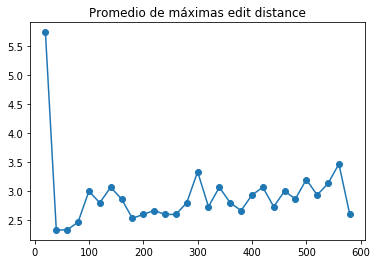

In [37]:
def max_promedio(words):
    stranger_words = sorted(list(words.items()), key=lambda x: -x[1][0])[:15]
    
    return np.array([d for _, (d, _) in stranger_words]).mean()


pd.Series({k:max_promedio(v) for k, v in distances.items()}).plot(marker="o")

plt.title("Promedio de máximas edit distance")

Me parece que este análisis no echa mucha luz sobre el asunto... Lo único que quizás puede verse es que las primeras palabras no tienen, muchas veces, una forma normalizada. De movida, sacaría todas las palabras con menos de 20 ocurrencias.

En el final, yo creo que deberíamos normalizar el texto, y eventualmente ahí ver qué hacer con las otras palabras. Esto lo estamos haciendo con un remache del problema previo que tuvimos.

Algo que podríamos intentar argumentar: ¿cuánto "vocabulario" es relevante? 

